In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [ ]:
!pip install --upgrade kaggle==1.6.17 --force-reinstall --no-deps
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    # Put your kaggle username & key here
    f.write('{"username":"rghosh2","key":"848a64f2efdca85354ed5b82d5e60af9"}')

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=872f9b22968441d7f9344de8a92136311db77c6297555605a73493ffd92c6e4a
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 7.23MB/s]


In [ ]:
!unzip -qo /content/house-prices-advanced-regression-techniques.zip -d '/content'

In [ ]:
# =============================================================================
# 1. Data Loading & Initial Inspection
# =============================================================================
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')  # Optional for future use

print("Initial dataset shape:", train_df.shape)
print("\nFirst 5 rows:")
print(train_df.head())


Initial dataset shape: (1460, 81)

First 5 rows:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType 

In [ ]:
# =============================================================================
# 2. Data Cleaning & Preprocessing
# =============================================================================

# Manually defined numerical features (continuous/discrete quantities)
num_cols = [
    'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
    'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
    'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'
]

# Manually defined categorical features (nominal/ordinal categories)
cat_cols = [
    'MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
    'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
    'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
    'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
    'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
    'GarageQual', 'GarageCond', 'PavedDrive',
    'SaleType', 'SaleCondition'
]

# Separate target early to prevent processing
target = 'SalePrice'
y = train_df[target].copy()
X = train_df.drop(columns=[target])

# Clean features only
# Drop high-missing columns
X = X.dropna(thresh=len(X)*0.5, axis=1)

# Impute missing values
#num_cols = X.select_dtypes(include=['number']).columns
#cat_cols = X.select_dtypes(include=['object']).columns


X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])

# Remove duplicates
X = X.drop_duplicates()

# Outlier removal (numeric only)
z_scores = np.abs(stats.zscore(X[num_cols]))
X = X[(z_scores < 3).all(axis=1)]

# Rejoin with target using index alignment
train_df = X.join(y.loc[X.index])

In [ ]:
feature_info = pd.DataFrame({
    'Feature': train_df.columns,
    'Data Type': train_df.dtypes
})
feature_info.to_csv('feature_data_types.csv', index=False)


Numeric features summary:
                        mean           std      min       max
Id                736.063230    422.283096      1.0    1457.0
MSSubClass         54.815175     41.675765     20.0     190.0
LotFrontage        67.502918     18.321403     21.0     134.0
LotArea          9203.829767   3726.082608   1300.0   34650.0
OverallQual         6.082685      1.330480      2.0      10.0
OverallCond         5.514591      0.983199      3.0       8.0
YearBuilt        1975.105058     29.089103   1885.0    2009.0
YearRemodAdd     1985.986381     20.806846   1950.0    2010.0
MasVnrArea         82.684825    130.152722      0.0     640.0
BsmtFinSF1        420.168288    407.750317      0.0    1646.0
BsmtFinSF2         18.436770     75.191886      0.0     506.0
BsmtUnfSF         579.424125    424.323650      0.0    1869.0
TotalBsmtSF      1018.029183    365.562515      0.0    2158.0
1stFlrSF         1103.163424    332.797029    438.0    2207.0
2ndFlrSF          323.489300    408.295434 

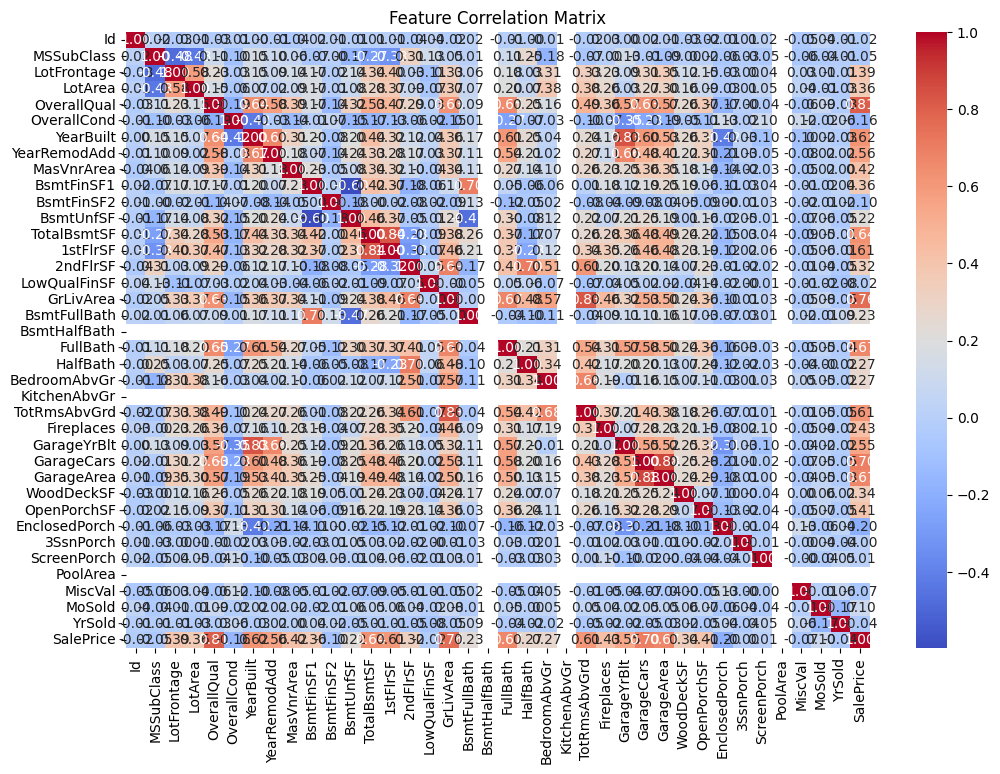

In [ ]:
# =============================================================================
# 3. Exploratory Data Analysis
# =============================================================================

# Numeric features analysis
numeric_df = train_df.select_dtypes(include=['number'])
print("\nNumeric features summary:")
print(numeric_df.describe().T[['mean', 'std', 'min', 'max']])

# Categorical features analysis
cat_summary = {col: train_df[col].value_counts().to_dict()
               for col in cat_cols if col in train_df.columns}
print("\nCategorical features summary:")
for col, counts in cat_summary.items():
    print(f"\n{col}:")
    print(counts)

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
# Drop 'Id' column if it exists
train_df = train_df.drop(columns=['Id'], errors='ignore')

# Numerical summary statistics
numerical_summary = train_df.describe().transpose()

# Create a DataFrame with feature data types
summary_df = pd.DataFrame({
    'Feature': train_df.columns,
    'Data Type': train_df.dtypes,
})

# Merge numerical summary statistics with the feature data types
full_summary = pd.merge(summary_df, numerical_summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']], left_on='Feature', right_index=True, how='left')

# Save the summary to a CSV
full_summary.to_csv('feature_characterization.csv', index=False)

print("Feature characterization saved to 'feature_characterization.csv'.")


Feature characterization saved to 'feature_characterization.csv'.



Validation R² Score: 0.922


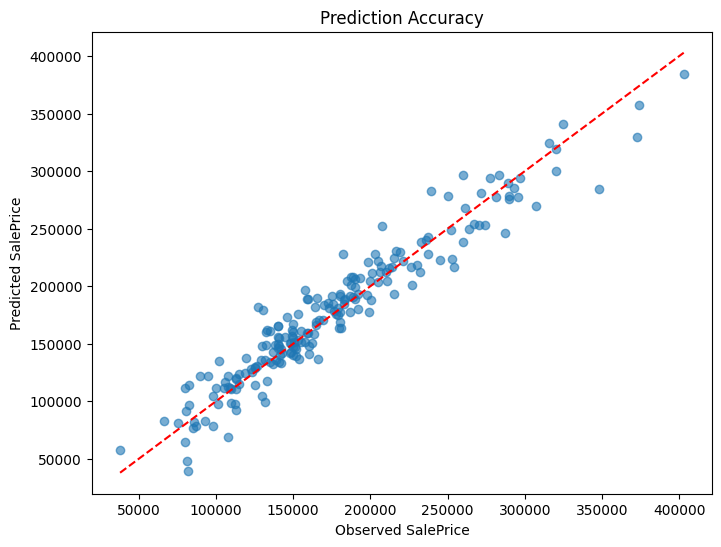

In [ ]:
# =============================================================================
# 4. Regression Pipeline & Evaluation
# =============================================================================

# Updated feature lists
numeric_features = num_cols
categorical_features = cat_cols

# Pipeline construction
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Data splitting
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(target, axis=1),
    train_df[target],
    test_size=0.2,
    random_state=42
)

# Model training
model_pipeline.fit(X_train, y_train)

# Validation
y_val_pred = model_pipeline.predict(X_val)
r2 = r2_score(y_val, y_val_pred)
print(f"\nValidation R² Score: {r2:.3f}")

# Predicted vs Observed plot
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Observed SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Prediction Accuracy')
plt.show()

In [ ]:
#=============================================================================
# 5. Feature Importance Analysis
# =============================================================================

# Get feature names
onehot_encoder = model_pipeline.named_steps['preprocessor']\
                               .named_transformers_['cat']\
                               .named_steps['onehot']
cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features)
all_features = numeric_features + cat_feature_names.tolist()

# Coefficient analysis
coefficients = model_pipeline.named_steps['regressor'].coef_
coef_df = pd.DataFrame({
    'feature': all_features,
    'coefficient': coefficients,
    'abs_coeff': np.abs(coefficients)
}).sort_values('abs_coeff', ascending=False)

print("\nTop 75 Predictive Features:")
print(coef_df.head(75))



Top 75 Predictive Features:
                  feature   coefficient     abs_coeff
95   Neighborhood_StoneBr  46456.604926  46456.604926
216        Functional_Mod -24028.722219  24028.722219
245          SaleType_CWD  23744.547998  23744.547998
49       MSZoning_C (all) -23210.937250  23210.937250
79   Neighborhood_Crawfor  21170.768368  21170.768368
..                    ...           ...           ...
247        SaleType_ConLD   5468.589766   5468.589766
224    GarageType_Basment  -5449.575589   5449.575589
41          MSSubClass_70   5375.392347   5375.392347
3             OverallCond   5354.569205   5354.569205
179       BsmtExposure_Mn  -5350.910470   5350.910470

[75 rows x 3 columns]


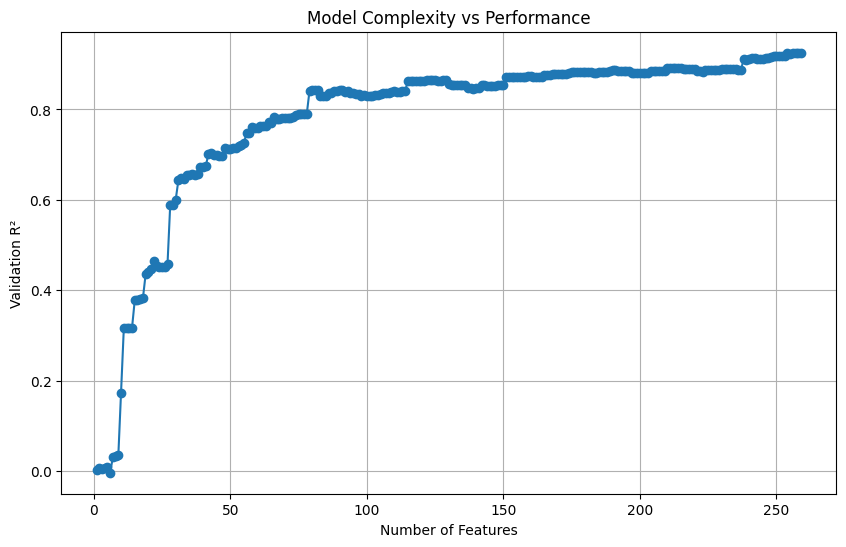

In [ ]:
# =============================================================================
# 6. Model Complexity Analysis
# =============================================================================

# Prepare transformed data
X_train_trans = model_pipeline['preprocessor'].transform(X_train)
X_val_trans = model_pipeline['preprocessor'].transform(X_val)

# Feature selection loop
complexity = []
r2_scores = []
sorted_indices = [all_features.index(feat) for feat in coef_df['feature']]

for n_features in range(1, X_train_trans.shape[1] + 1):
    lr = LinearRegression()
    lr.fit(X_train_trans[:, sorted_indices[:n_features]], y_train)
    preds = lr.predict(X_val_trans[:, sorted_indices[:n_features]])
    complexity.append(n_features)
    r2_scores.append(r2_score(y_val, preds))

# Complexity plot
plt.figure(figsize=(10, 6))
plt.plot(complexity, r2_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Validation R²')
plt.title('Model Complexity vs Performance')
plt.grid(True)
plt.show()


In [ ]:
# Get top 30 features from linear model
top_75 = coef_df['feature'].head(75).tolist()

# Get features with correlation >0.5
high_corr = numeric_df.corr()[target][abs(numeric_df.corr()[target]) > 0.5].index.tolist()

# Combine lists (remove duplicates)
final_features = list(set(top_75 + high_corr))
if 'SalePrice' in final_features:
    final_features.remove('SalePrice')

In [ ]:
final_features

['Condition1_Artery',
 'YearBuilt',
 'Electrical_FuseF',
 'SaleType_CWD',
 'SaleType_ConLD',
 '1stFlrSF',
 'SaleCondition_Alloca',
 'Neighborhood_Mitchel',
 'TotalBsmtSF',
 'ExterQual_Ex',
 'KitchenQual_Ex',
 'MSSubClass_30',
 'Heating_GasW',
 'MSSubClass_120',
 'Exterior1st_BrkFace',
 'MSSubClass_160',
 'Neighborhood_Somerst',
 'BsmtFinType2_GLQ',
 'SaleCondition_Partial',
 'RoofStyle_Gambrel',
 'TotRmsAbvGrd',
 'SaleType_COD',
 'Exterior2nd_Wd Shng',
 'GarageArea',
 'Foundation_BrkTil',
 'Condition1_PosN',
 'BsmtFinType1_GLQ',
 'OverallQual',
 'Neighborhood_Timber',
 'ExterQual_TA',
 'Neighborhood_NWAmes',
 'GarageQual_Fa',
 'Neighborhood_SWISU',
 'Neighborhood_CollgCr',
 'BldgType_1Fam',
 'Heating_Wall',
 'PavedDrive_P',
 'Exterior2nd_Wd Sdng',
 'MSZoning_RH',
 'Exterior2nd_CmentBd',
 'Exterior1st_AsbShng',
 'GrLivArea',
 'GarageType_Basment',
 'Neighborhood_Blmngtn',
 'SaleType_WD',
 'Neighborhood_MeadowV',
 'OverallCond',
 'BsmtFinType2_Rec',
 'Neighborhood_Edwards',
 'RoofMatl_Co

In [ ]:
# =============================================================================
# 7. Advanced Model Training and Evaluation
# =============================================================================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# First split: separate test set
X_initial, X_test, y_initial, y_test = train_test_split(
    train_df.drop(target, axis=1),
    train_df[target],
    test_size=0.2,
    random_state=42,
    stratify=pd.qcut(train_df[target], q=5, labels=False)  # Stratify by price quintiles
)

# Second split: separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_initial,
    y_initial,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of original data
    random_state=42,
    stratify=pd.qcut(y_initial, q=5, labels=False)
)

print("Data partition sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Data partition sizes:
Training set: 616 samples
Validation set: 206 samples
Test set: 206 samples


In [ ]:
# Define model pipelines
def create_model_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

# Initialize models
models = {
    # Complex models
    'Random Forest': create_model_pipeline(
        RandomForestRegressor(n_estimators=100, random_state=42)
    ),
    'Neural Network': create_model_pipeline(
        MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
    ),
    # Simple models
    'Decision Tree': create_model_pipeline(
        DecisionTreeRegressor(max_depth=5, random_state=42)
    ),
    'KNN': create_model_pipeline(
        KNeighborsRegressor(n_neighbors=5)
    )
}

# ------------------- ADDED CODE -------------------
# Import XGBoost Regressor (if not already imported)
from xgboost import XGBRegressor

# Additional complex model: XGBoost Regressor
models['XGBoost'] = create_model_pipeline(
    XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
)
# ------------------- END ADDED CODE -------------------


Training Random Forest...

Training Neural Network...

Training Decision Tree...

Training KNN...

Training XGBoost...

Model Performance Comparison:
                      R2          RMSE           MAE
Random Forest   0.898754  20974.238829  15202.966748
Neural Network  0.833622  26887.229079  20062.351210
Decision Tree   0.737576  33767.518198  24543.837456
KNN             0.705325  35782.386659  25131.123301
XGBoost         0.903491  20477.736594  14850.616211


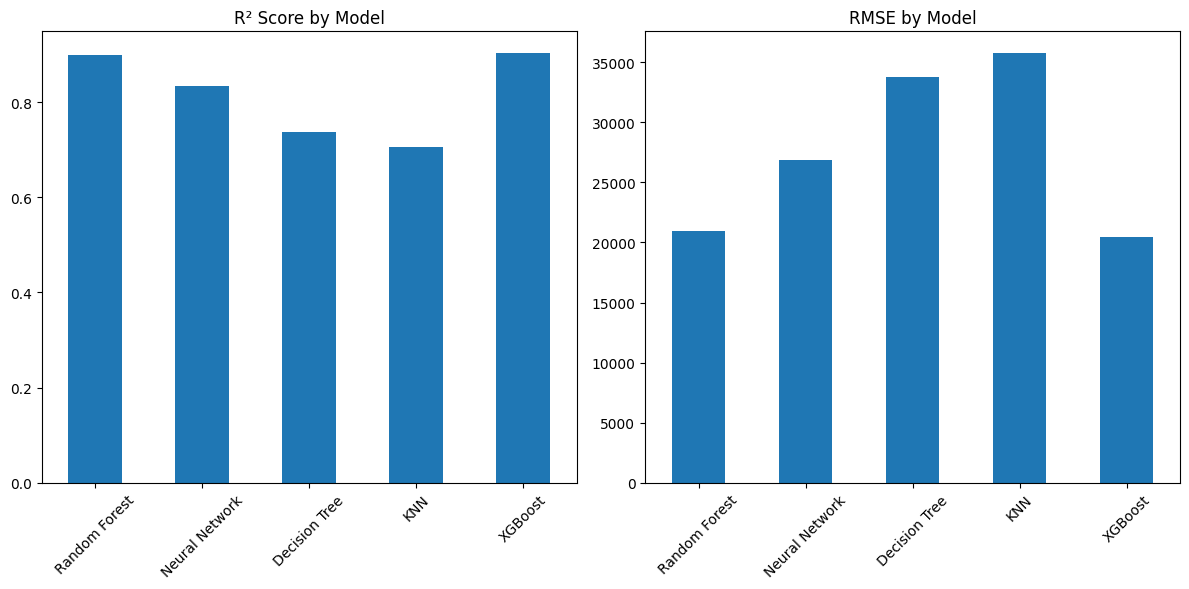

In [ ]:
# Train and evaluate models
results = {}
for name, pipeline in models.items():
    print(f"\nTraining {name}...")
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_val_pred = pipeline.predict(X_val)

    # Calculate metrics
    results[name] = {
        'R2': r2_score(y_val, y_val_pred),
        'RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'MAE': mean_absolute_error(y_val, y_val_pred)
    }

# Create performance comparison DataFrame
performance_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(performance_df)

# Visualize model performance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
performance_df['R2'].plot(kind='bar')
plt.title('R² Score by Model')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 2, 2)
performance_df['RMSE'].plot(kind='bar')
plt.title('RMSE by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

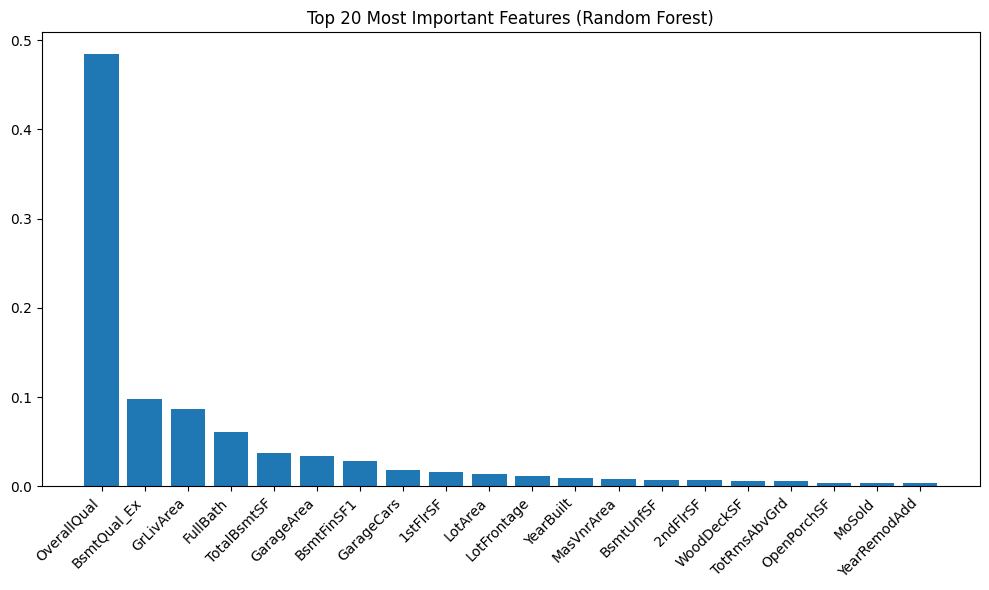


Best Model (XGBoost) Performance on Test Set:
R² Score: 0.854
RMSE: 24481.473
MAE: 15426.631


In [ ]:
# Feature importance for Random Forest (example of model interpretability)
rf_model = models['Random Forest'].named_steps['regressor']
rf_features = (numeric_features +
               models['Random Forest'].named_steps['preprocessor']
               .named_transformers_['cat']
               .named_steps['onehot']
               .get_feature_names_out(categorical_features).tolist())

feature_importance = pd.DataFrame({
    'feature': rf_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(range(20), feature_importance['importance'][:20])
plt.xticks(range(20), feature_importance['feature'][:20], rotation=45, ha='right')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

# Evaluate best model on test set
best_model_name = performance_df['R2'].idxmax()
best_model = models[best_model_name]
y_test_pred = best_model.predict(X_test)

print(f"\nBest Model ({best_model_name}) Performance on Test Set:")
print(f"R² Score: {r2_score(y_test, y_test_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.3f}")


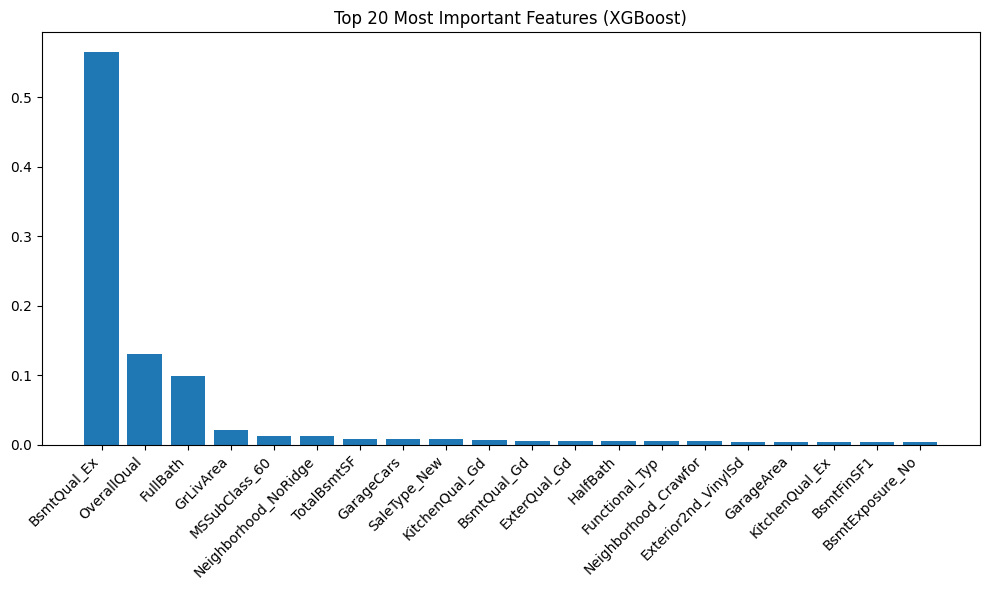

In [ ]:
if best_model_name == 'XGBoost':
    xgb_model = models['XGBoost'].named_steps['regressor']
    xgb_features = (
        numeric_features +
        models['XGBoost'].named_steps['preprocessor']
            .named_transformers_['cat']
            .named_steps['onehot']
            .get_feature_names_out(categorical_features).tolist()
    )

    xgb_importances = xgb_model.feature_importances_
    feature_importance_xgb = pd.DataFrame({
        'feature': xgb_features,
        'importance': xgb_importances
    }).sort_values('importance', ascending=False)

    # Plot top 20
    plt.figure(figsize=(10, 6))
    plt.bar(range(20), feature_importance_xgb['importance'][:20])
    plt.xticks(range(20), feature_importance_xgb['feature'][:20],
               rotation=45, ha='right')
    plt.title('Top 20 Most Important Features (XGBoost)')
    plt.tight_layout()
    plt.show()
